###  사전 준비

In [12]:
# 기본 패키지 import
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# 한글 설정 / 차트 마이너스 깨짐 현상 해결 / seaborn 화면 설정
from matplotlib import rc
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')
sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='darkgrid')

### MNIST 다운로드

In [14]:
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
from sklearn.model_selection import train_test_split

In [15]:
(train_input, train_target), (test_input, test_target) = load_data()

In [16]:
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [17]:
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

In [18]:
# MNIST 이미지 표현
def show_images(dataset, label, nrow, ncol):
    # 캔버스 설정
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(2*ncol, 2*nrow))
    ax = axes.ravel()

    xlabels = label[0:nrow*ncol]

    for i in range(nrow*ncol):
        image = dataset[i]
        ax[i].imshow(image, cmap='gray_r')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlabel(xlabels[i])
    
    plt.tight_layout()
    plt.show()

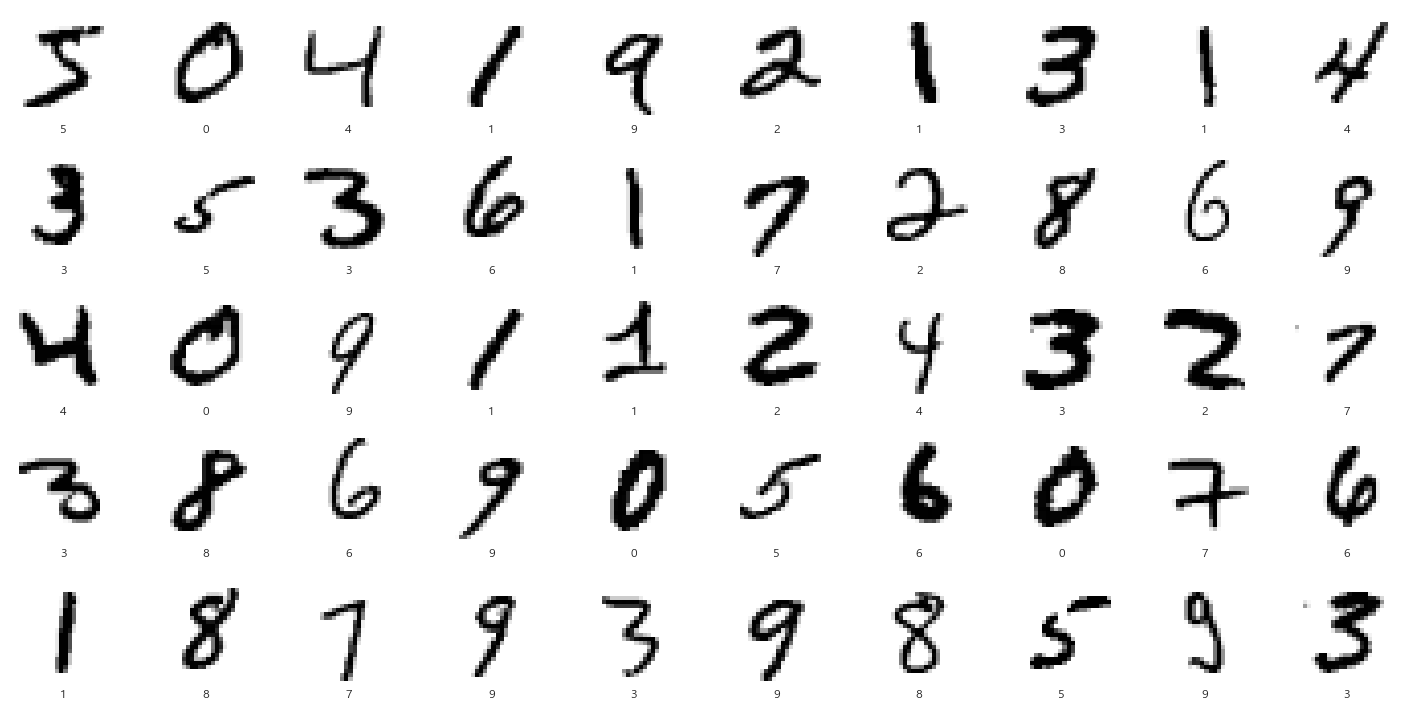

In [19]:
show_images(train_input, train_target, 5, 10)

In [23]:
model = keras.Sequential(name='CNN')
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2)) # 14X14 특성맵이 32개
model.add(keras.layers.Conv2D(64,kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2)) # 7X7 특성맵이 64개
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000,activation='relu',name='hidden'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10,activation='softmax',name='output'))
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 3136)              0         
                                                                 
 hidden (Dense)              (None, 1000)              3137000 

In [24]:
# 255.0으로 나눠서 0~1로 값 축소하는 일은 안함
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/best_cnn_model.h5', save_best_only=True, verbose=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_input, train_target, epochs=20, verbose=1, validation_data=(test_input, test_target), batch_size=100, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
600/600 [==============================] - ETA: 0s - loss: 0.9398 - accuracy: 0.9370
Epoch 1: val_loss improved from inf to 0.05451, saving model to ./data\best_cnn_model.h5
600/600 [==============================] - 47s 78ms/step - loss: 0.9398 - accuracy: 0.9370 - val_loss: 0.0545 - val_accuracy: 0.9808
Epoch 2/20
600/600 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9802
Epoch 2: val_loss improved from 0.05451 to 0.04548, saving model to ./data\best_cnn_model.h5
600/600 [==============================] - 51s 84ms/step - loss: 0.0622 - accuracy: 0.9802 - val_loss: 0.0455 - val_accuracy: 0.9854
Epoch 3/20
600/600 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9864
Epoch 3: val_loss did not improve from 0.04548
600/600 [==============================] - 53s 89ms/step - loss: 0.0436 - accuracy: 0.9864 - val_loss: 0.0477 - val_accuracy: 0.9839
Epoch 4/20
600/600 [==============================] - ETA: 0s - loss: 0.0386 - accur

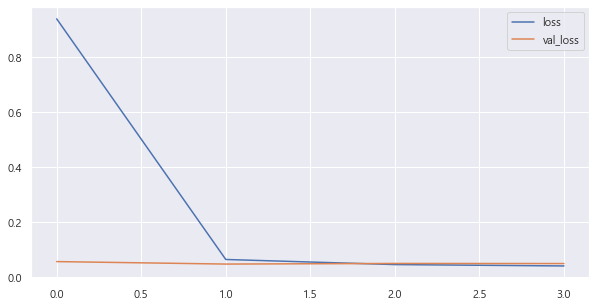

In [25]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(10,5))

for each in plot_target:
    plt.plot(history.history[each], label=each)
plt.legend()
plt.show()

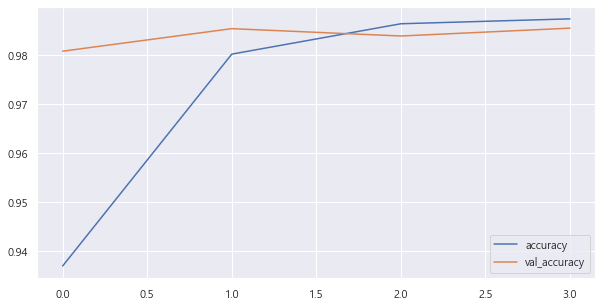

In [26]:
plot_target = ['accuracy', 'val_accuracy']
plt.figure(figsize=(10,5))

for each in plot_target:
    plt.plot(history.history[each], label=each)
plt.legend()
plt.show()

In [27]:
model.evaluate(test_input, test_target)

313/313 [==============================] - 3s 8ms/step - loss: 0.0455 - accuracy: 0.9854


[0.04547975957393646, 0.9854000210762024]

In [28]:
# 예측된 결과값 리스트
pred_result = model.predict(test_input)

313/313 [==============================] - 3s 8ms/step


In [29]:
pred_labels = np.argmax(pred_result, axis=-1)
pred_labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [30]:
pred_labels.shape

(10000,)

#### 예측 실패한 이미지 파악

In [32]:
wrong_result = []

for i in range(0, len(test_target)):
    if pred_labels[i] != test_target[i]:
        wrong_result.append(i)

len(wrong_result)

146

In [33]:
import random

samples = random.choices(population=wrong_result, k=16)
len(samples)

16

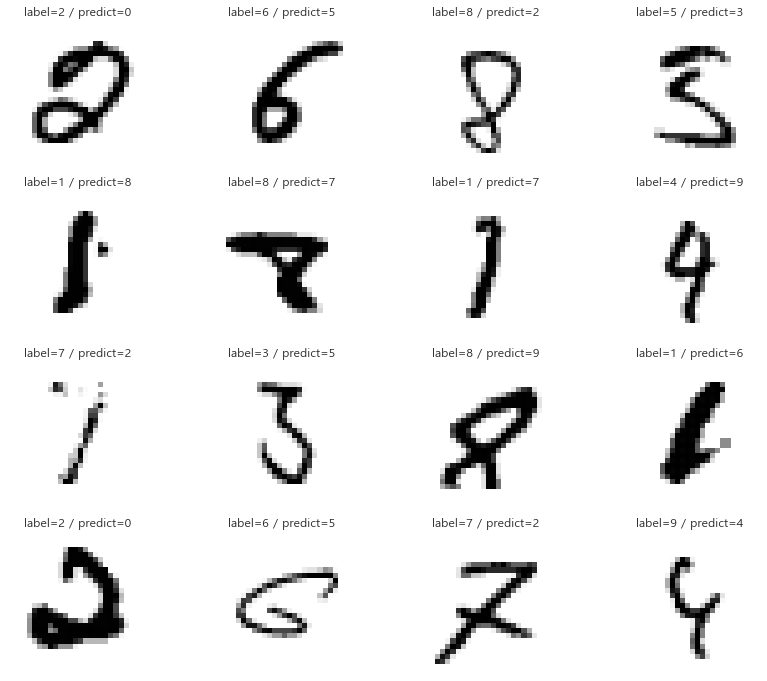

In [34]:
# 예측 실패한 이미지 확인
plt.figure(figsize=(14,12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(test_input[n].reshape(28,28), cmap='gray_r', interpolation='nearest')
    plt.title(f'label={test_target[n]} / predict={pred_labels[n]}')
    plt.axis('off')
plt.show()